In [13]:
# Install necessary libraries
!pip install scikit-learn seaborn matplotlib wordcloud pandas

In [14]:
# Import required libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.svm import LinearSVC
from sklearn.linear_model import SGDClassifier
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from scipy.sparse import hstack
from wordcloud import WordCloud, STOPWORDS

In [15]:
# Function to load the dataset
def load_dataset(file_path):
    dataset = pd.read_csv(file_path)
    print("Available columns in the dataset:", dataset.columns)
    return dataset

In [16]:
# Function to handle missing data
def handle_missing_data(dataset):
    if 'reviews.didPurchase' in dataset.columns:
        dataset['reviews.didPurchase'] = dataset['reviews.didPurchase'].fillna('Not Available')
    dataset = dataset.dropna()
    print("Remaining missing values:\n", dataset.isnull().sum())
    return dataset

In [17]:
# Function to visualize rating distribution
def visualize_rating_distribution(dataset):
    if 'reviews.rating' in dataset.columns:
        rating_counts = dataset['reviews.rating'].value_counts()
        sns.barplot(x=rating_counts.index, y=rating_counts.values)
        plt.xlabel("Rating")
        plt.ylabel("Frequency")
        plt.title("Distribution of Ratings")
        plt.show()

In [18]:
# Function to visualize purchase status distribution
def visualize_purchase_status(dataset):
    if 'reviews.didPurchase' in dataset.columns:
        ax_plt = sns.countplot(dataset['reviews.didPurchase'])
        ax_plt.set_xlabel("Purchase Status")
        ax_plt.set_ylabel("Review Count")
        ax_plt.set_title("Purchase Status Distribution")
        plt.show()

In [19]:
# Function to generate a word cloud for reviews
def generate_wordcloud(data, title=None):
    stopwords = set(STOPWORDS)
    wc = WordCloud(background_color='white', stopwords=stopwords, max_words=250,
                   max_font_size=30, scale=2, random_state=5).generate(str(data))
    plt.figure(figsize=(15, 15))
    plt.imshow(wc, interpolation='bilinear')
    plt.axis('off')
    if title:
        plt.title(title, fontsize=20)
    plt.show()

In [20]:
# Function to preprocess text data
def preprocess_text(data):
    # Word-level and character-level TF-IDF vectorization
    vectorize_word = TfidfVectorizer(sublinear_tf=True, strip_accents='unicode', analyzer='word',
                                     token_pattern=r'\w{1,}', stop_words='english', ngram_range=(1, 1), max_features=10000)
    train_features_word = vectorize_word.fit_transform(data)

    vectorize_char = TfidfVectorizer(sublinear_tf=True, strip_accents='unicode', analyzer='char',
                                     ngram_range=(2, 6), max_features=50000)
    train_features_char = vectorize_char.fit_transform(data)

    # Combine both features
    train_features = hstack([train_features_char, train_features_word])

    return train_features

In [21]:
# Function to split the dataset
def split_dataset(features, target, test_size=0.3, random_state=101):
    X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=test_size,
                                                        random_state=random_state, shuffle=True)
    return X_train, X_test, y_train, y_test

In [22]:
# Function to train and evaluate models
def train_and_evaluate(model, X_train, X_test, y_train, y_test, model_name):
    model.fit(X_train, y_train)

    # Predictions
    pred_train = model.predict(X_train)
    pred_test = model.predict(X_test)

    # Displaying results
    print(f"{model_name} - Training Accuracy:", accuracy_score(y_train, pred_train))
    print(classification_report(y_train, pred_train))

    print(f"{model_name} - Testing Accuracy:", accuracy_score(y_test, pred_test))
    print(classification_report(y_test, pred_test))

    # Confusion Matrix
    cm = confusion_matrix(y_test, pred_test, normalize='true')
    sns.heatmap(cm, annot=True, fmt='.2%', cmap='Blues', xticklabels=model.classes_, yticklabels=model.classes_)
    plt.xlabel("Predicted Labels")
    plt.ylabel("True Labels")
    plt.title(f"Confusion Matrix for {model_name}")
    plt.show()

Available columns in the dataset: Index(['Unnamed: 0', 'brand', 'categories', 'manufacturer', 'reviews.rating',
       'reviews.text', 'label', 'reviews.text_reduce'],
      dtype='object')
Remaining missing values:
 brand             0
manufacturer      0
reviews.rating    0
reviews.text      0
dtype: int64


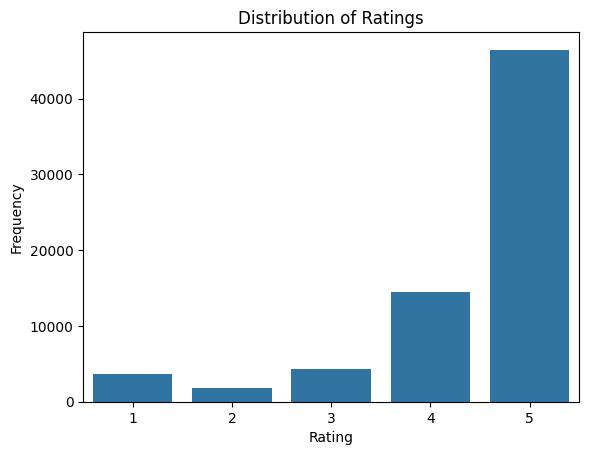

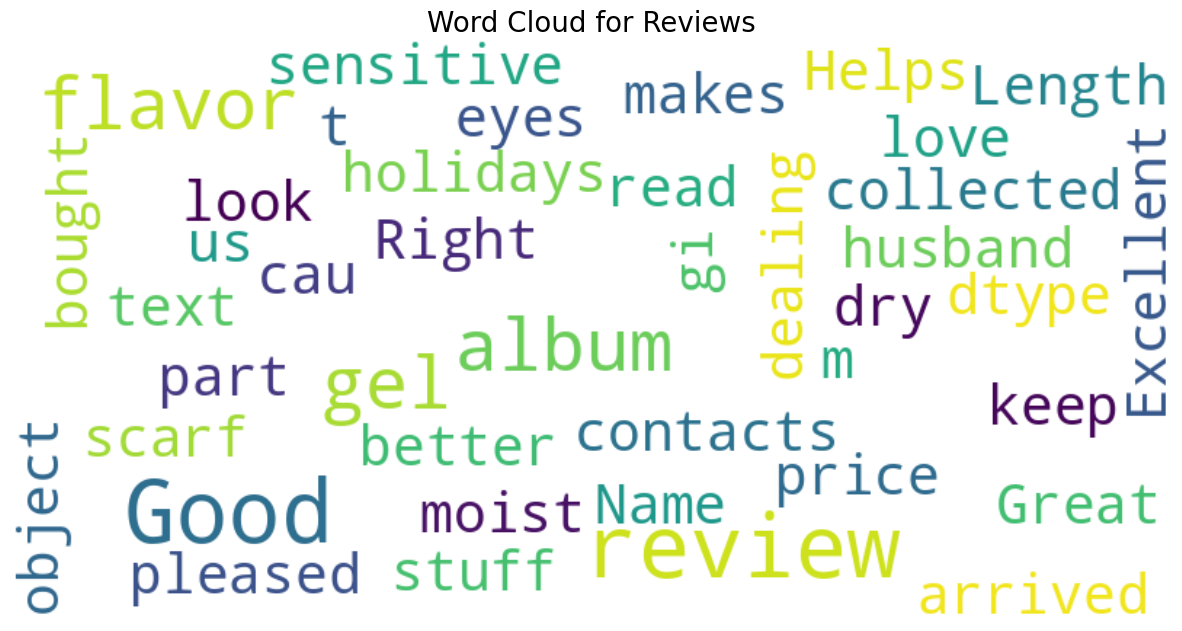

In [ ]:
# Main function to process the dataset
def main():
    # Load dataset
    dataset = load_dataset('/content/p3.csv')

    # Select relevant columns and handle missing data
    available_columns = ['brand', 'manufacturer', 'reviews.didPurchase', 'reviews.rating', 'reviews.text']
    dataset = dataset[[col for col in available_columns if col in dataset.columns]]
    dataset = handle_missing_data(dataset)

    # Visualize the data
    visualize_rating_distribution(dataset)
    visualize_purchase_status(dataset)
    generate_wordcloud(dataset['reviews.text'], title="Word Cloud for Reviews")

    # Preprocess text and create target labels
    if 'reviews.text' in dataset.columns and 'reviews.rating' in dataset.columns:
        data = dataset['reviews.text']
        y_target = dataset['reviews.rating'].map({1: 'Unhappy', 2: 'Unhappy', 3: 'Neutral', 4: 'Happy', 5: 'Happy'})

        # Preprocess text data
        train_features = preprocess_text(data)

        # Split the dataset
        X_train, X_test, y_train, y_test = split_dataset(train_features, y_target)

        # Train and evaluate LinearSVC
        lsvm = LinearSVC(class_weight='balanced')
        train_and_evaluate(lsvm, X_train, X_test, y_train, y_test, "LinearSVC")

        # Train and evaluate SGD Classifier
        sgd = SGDClassifier(class_weight='balanced', max_iter=300, n_jobs=-1)
        train_and_evaluate(sgd, X_train, X_test, y_train, y_test, "SGDClassifier")

# Run the main function
if __name__ == "__main__":
    main()